# Imports

In [25]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.integrate import quad
from scipy.stats import multivariate_normal
from scipy.stats import truncnorm
from scipy.stats import norm
import scipy.integrate as integrate

# Functions

In [2]:
def pdf(x, mean, variance):
    """ One-Diemensional standard gaussian PDF """
    return (np.exp(-(x-mean)**2 / (2*variance))) * (1/(np.sqrt(2 * np.pi * variance)))

def pdf_t(t, variance, mean, y):
    """  p(t|s1,s2,y): The full conditional distribution of the outcome """
    if y==1:
        return np.where((0 < t), pdf(t, mean, variance), 0)  # return 0 if t lower than 0
    else: # y=-1
        return np.where((0 > t), pdf(t, mean, variance), 0)  # return 0 if t higher than 0
        

def plot_function(x,y):
    """ Standard 1D plotting function """
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot the data
    ax.plot(x, y, label='PDF')

    # Set labels and title
    ax.set_xlabel('t')
    ax.set_ylabel('p(t)')
    ax.set_title('PDF')
    ax.legend()
    ax.grid(True)

    # Show the plot
    plt.show()
    
    
def prob_from_pdf(mean, variance, lower, upper):
    """ Integrate PDF within range to get probability"""
    return quad(pdf, lower, upper, args=(mean, variance))


def plot_3d_gaussian(mean_vec, variance_mat):
    """ Given a mean vector and covariance matrix generate a 3D plot of the distribution """
    # Create a grid
    x, y = np.linspace(-10, 10, 100), np.linspace(-10, 10, 100)
    x, y = np.meshgrid(x, y)
    pos = np.dstack((x, y))

    # Create a 3D Gaussian surface
    rv = multivariate_normal(mean_vec.flatten(), variance_mat)
    z = rv.pdf(pos)

    # Create the 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, z, cmap='viridis')

    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Probability Density')

    plt.show()
    

## Variables

In [3]:
# Mean
mu_1 = 1
mu_2 = -1

# Variances
var_1 = 1
var_2 = 4
var_t = 5

# Random Variables
s_1 = 1
s_2 = -1
t = 3

## Q3

###  Compute p(s1, s2|t, y)

p(s1, s2|t, y): the full conditional distribution of the skills

Given that we know the (distribution) outcome of the match. Generate a gaussian representing the skills

Sigma matrix:
 [[0.9 0.4]
 [0.4 2.4]]

Mean vector:
 [[ 1.1]
 [-1.4]]

3D-Plot:


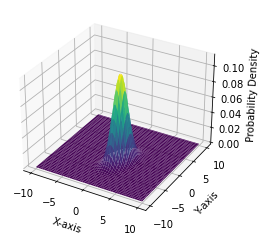

In [4]:
#### Covariance Sigma
S_11 = var_1*(var_2+var_t) / (var_1+var_2+var_t)
S_12 = var_1*var_2 / (var_1+var_2+var_t)
S_21 = S_12
S_22 = var_2*(var_1+var_t) / (var_1+var_2+var_t)

sigma_ab = np.array([[S_11, S_12],[S_21, S_22]])
print(f"Sigma matrix:\n {sigma_ab}")


### Mean Mu
U_1 = (var_1*(t+mu_2) + mu_1*(var_2+var_t)) / (var_1+var_2+var_t)
U_2 = (var_2*(mu_1-t) + mu_2*(var_1+var_t)) / (var_1+var_2+var_t)

mu_ab = np.array([[U_1],[U_2]]) 
print(f"\nMean vector:\n {mu_ab}")



### Plot the 3D gaussian
print("\n3D-Plot:")

plot_3d_gaussian(mu_ab, sigma_ab)

### Compute p(t | s1, s2, y)

p(t | s1, s2, y) = N(s1-s2, var_t): The full conditional distribution of the outcome

Given that we know the outcome and the player skills, generate a gaussian of the distribution of the outcome

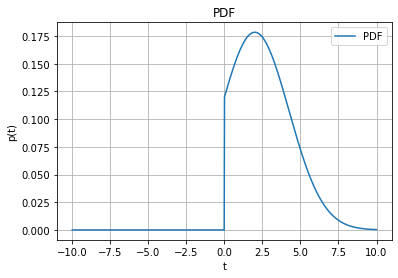

In [5]:
# Define variables
mu_t = s_1-s_2

# Set outcome
y=1

# Define x and y
t = np.linspace(-10,10,1000)
p = pdf_t(t, var_t, mu_t, y)

plot_function(t,p)

### Compute p(y = 1)

Probability that player 1 wins is equal:        p(y=1) = p(t>0)

Probability that player 2 wins is equal:        p(y=-1) = p(t<0)   or    1-p(y=1)

In [6]:
# Define mean and variance for p(t)
mean = mu_1 - mu_2
variance = var_1 + var_2 + var_t

# Range
a = 0
b = np.inf

# Integrate
integral_value, _ = prob_from_pdf(mean,variance,a,b)

# Output
print(f"Mean = {mean}")
print(f"Variance = {variance}")
print(f"Probability = {integral_value}")

Mean = 2
Variance = 10
Probability = 0.7364553715672308


## Q4 - Gibbs sampler

### How to compute p(s1,s2 | y)

Initially we know p(s1), p(s2) and y. We want to compute p(s1,s2 | y)

1. Calculate p(t | s1,s2,y) according to question 2 from Q3 (sample from truncated gaussian)

2. Calculate p(s1,s2 | t) according to question 1 from Q3

### Troubleshooting and plots

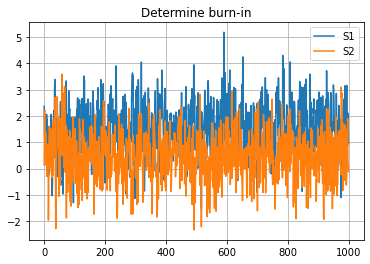

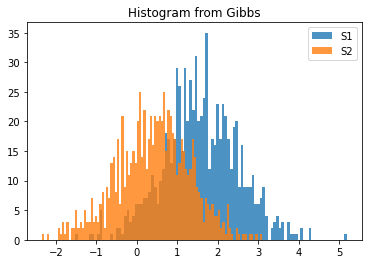

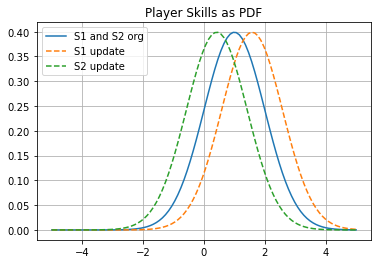

In [7]:
### Gibbs Sampling Settings
N = 1000  # Total number of samples
B = N//5    # Burn-in

### Initiating player skills: Same hyperparameters for p(s1) and p(s2)
# Player 1
mean_s1 = 1
var_s1 = 1
std_s1 = np.sqrt(var_s1)
# Player 2
mean_s2 = mean_s1
var_s2 = var_s1
std_s2 = std_s1


### Match setting 
y = 1 # player 1 wins
if y==1:
    lower_bound = 0
    upper_bound = np.inf
elif y==-1:
    lower_bound = -np.inf
    upper_bound = 0


### Initial values
s1_samples = np.zeros(N)
s2_samples = np.zeros(N)
s1_samples[0] = np.random.normal(mean_s1, std_s1) 
s2_samples[0] = np.random.normal(mean_s2, std_s2) 


############################## Gibbs sampling ############################## 
for i in range(N-1): 
    ### Sample from p(t | s1,s2,y)
    mean_t = s1_samples[i] - s2_samples[i]
    var_t = var_s1 + var_s2 
    t_sample = truncnorm.rvs(lower_bound, upper_bound, loc=mean_t, scale=np.sqrt(var_t))

    
    ### Sample from p(s1,s2 | t) 
    # Covariance matrix
    S_11 = var_s1*(var_s2+var_t) / (var_s1+var_s2+var_t)
    S_12 = var_s1*var_s2 / (var_s1+var_s2+var_t)
    S_21 = S_12
    S_22 = var_s2*(var_s1+var_t) / (var_s1+var_s2+var_t)
    covar_mat = np.array([[S_11, S_12],[S_21, S_22]])

    # Mean vector
    U_1 = (var_s1*(t_sample+mean_s2) + mean_s1*(var_s2+var_t)) / (var_s1+var_s2+var_t)
    U_2 = (var_s2*(mean_s1-t_sample) + mean_s2*(var_s1+var_t)) / (var_s1+var_s2+var_t)
    mean_vec = np.array([[U_1],[U_2]]) 
    
    # Draw sample of s1 and s2
    s1_sample, s2_sample = np.random.multivariate_normal(mean_vec.flatten(), covar_mat, 1).T
    
    s1_samples[i+1] = s1_sample
    s2_samples[i+1] = s2_sample

    

############################## Determine burn-in ############################## 
plt.plot(s1_samples,label="S1")
plt.plot(s2_samples,label="S2")
plt.title("Determine burn-in")
plt.grid()
plt.legend()
plt.show()
    
# Discard burn-in
final_s1_samples = s1_samples[B:]
final_s2_samples = s2_samples[B:]
       
    
    
    
    
############################## Plot Histogram of Gibbs sampling ############################## 
plt.hist(final_s1_samples,bins=100, alpha=0.8,label="S1")
plt.hist(final_s2_samples,bins=100, alpha=0.8,label="S2")
plt.title("Histogram from Gibbs")
plt.legend()
plt.show()



    
    
############################## Plot PDFs before and after sampling ############################## 
xv = np.linspace(-5,5,100)
plt.plot(xv, 1 / (std_s1 * np.sqrt(2 * np.pi)) * np.exp(-.5 * ((xv - mean_s1) / std_s1) ** 2), label="S1 and S2 org")  
#plt.plot(xv, 1 / (std_s2 * np.sqrt(2 * np.pi)) * np.exp(-.5 * ((xv - mean_s2) / std_s2) ** 2), label="S2 org")

# Print and update posterior mean and variance
post_mean_s1 = np.mean(final_s1_samples)
post_var_s1 = np.var(final_s1_samples)
post_mean_s2 = np.mean(final_s2_samples)
post_var_s2 = np.var(final_s2_samples)

plt.plot(xv, 1 / (std_s1 * np.sqrt(2 * np.pi)) * np.exp(-.5 * ((xv - post_mean_s1) / std_s1) ** 2), label="S1 update", linestyle='--')  
plt.plot(xv, 1 / (std_s2 * np.sqrt(2 * np.pi)) * np.exp(-.5 * ((xv - post_mean_s2) / std_s2) ** 2), label="S2 update", linestyle='--')

plt.title("Player Skills as PDF")
plt.grid()
plt.legend()
plt.show()


### Complete function

In [8]:
def gibbs_sampling(S1,S2,y,N,B):
    """ 
    Input:
        S1 is dictionary for player 1
        S2 is dictionary for player 2
        y is outcome of match
        N is how many samples to take
        B is burn_in index
        
    Return:
        Updated S1 dictionary
        Updated S2 dicitonary
    """
    ### Approximate variance for t
    var_t = S1["variance"] + S2["variance"]
    std_t = np.sqrt(var_t)
    
    ### Extract values from dicts
    mean_s1, var_s1 = S1["mean"], S1["variance"]
    mean_s2, var_s2 = S2["mean"], S2["variance"]
    std_s1, std_s2 = np.sqrt(var_s1), np.sqrt(var_s2)
    
    ### Match setting 
    if y==1:
        lower_bound = 0
        upper_bound = np.inf
    elif y==-1:
        lower_bound = -np.inf
        upper_bound = 0

    ### Sample initial values for s1 and s2
    s1_samples, s2_samples = np.zeros(N), np.zeros(N)
    s1_samples[0], s2_samples[0] = np.random.normal(mean_s1, std_s1), np.random.normal(mean_s2, std_s2) 

    ############################## Gibbs sampling ############################## 
    for i in range(N-1): 
        ### Sample from p(t | s1,s2,y)
        mean_t = s1_samples[i] - s2_samples[i]
        t_sample = truncnorm.rvs(lower_bound, upper_bound, loc=mean_t, scale=std_t)

        ### Sample from p(s1,s2 | t) 
        # Covariance matrix
        S_11 = var_s1*(var_s2+var_t) / (var_s1+var_s2+var_t)
        S_12 = var_s1*var_s2 / (var_s1+var_s2+var_t)
        S_21 = S_12
        S_22 = var_s2*(var_s1+var_t) / (var_s1+var_s2+var_t)
        covar_mat = np.array([[S_11, S_12],[S_21, S_22]])

        # Mean vector
        U_1 = (var_s1*(t_sample+mean_s2) + mean_s1*(var_s2+var_t)) / (var_s1+var_s2+var_t)
        U_2 = (var_s2*(mean_s1-t_sample) + mean_s2*(var_s1+var_t)) / (var_s1+var_s2+var_t)
        mean_vec = np.array([[U_1],[U_2]]) 

        # Draw sample of s1 and s2
        s1_sample, s2_sample = np.random.multivariate_normal(mean_vec.flatten(), covar_mat, 1).T
        s1_samples[i+1] = s1_sample
        s2_samples[i+1] = s2_sample
    
    ### Discard burn-in
    final_s1_samples = s1_samples[B:]
    final_s2_samples = s2_samples[B:]

    ### Update player dictionaries
    S1["mean"] = np.mean(final_s1_samples)
    S1["variance"] = np.var(final_s1_samples)
    S2["mean"] = np.mean(final_s2_samples)
    S2["variance"] = np.var(final_s2_samples)
    
    return S1, S2

### Test Gibbs

In [9]:
### Match setup
S1 = {"mean": 1, "variance": 1}
S2 = {"mean": 1, "variance": 1}
y = 1 # who wins
N = 1000
B = N//5

S1, S2 = gibbs_sampling(S1,S2,y,N,B)

print("S1:")
print(f"   Updated Mean: {S1['mean']}")
print(f"   Updated Variance: {S1['variance']}")
print("S2:")
print(f"   Updated Mean: {S2['mean']}")
print(f"   Updated Variance: {S2['variance']}")

S1:
   Updated Mean: 1.603802904773812
   Updated Variance: 0.9981160850400497
S2:
   Updated Mean: 0.4136665870775494
   Updated Variance: 0.8947878041856615


# Q5

In [10]:
#################### Read data #################### 
df = pd.read_csv('SerieA.csv')

print(df.head())
print(df.size)

   yyyy-mm-dd  HH:MM     team1     team2  score1  score2
0  2018-08-18  18:00    Chievo  Juventus       2       3
1  2018-08-18  20:30     Lazio    Napoli       1       2
2  2018-08-19  18:00    Torino      Roma       0       1
3  2018-08-19  20:30  Sassuolo     Inter       1       0
4  2018-08-19  20:30     Parma   Udinese       2       2
2280


In [11]:
####################  Preprocess data #################### 
# Drop columns with no relevant info
df.drop(['yyyy-mm-dd', 'HH:MM'], axis=1, inplace=True)

# Drop rows where game is even
df = df[df['score1'] != df['score2']]

print(df.head())
print(df.size)

      team1     team2  score1  score2
0    Chievo  Juventus       2       3
1     Lazio    Napoli       1       2
2    Torino      Roma       0       1
3  Sassuolo     Inter       1       0
5    Empoli  Cagliari       2       0
1088


In [37]:
#################### Find unique teams and create list of dictionaries ####################
unique_teams = pd.concat([df['team1'], df['team2']]).drop_duplicates().tolist()

# Initiate
initial_mean = 25
initial_variance = (25/3)

def initiate_teams(initial_mean, initial_variance):
    team_dicts = {}
    for team in unique_teams:
        team_dicts[team] = {
            'mean': initial_mean,
            'variance': initial_variance
        }
    return team_dicts

team_dicts = initiate_teams(initial_mean, initial_variance)


In [38]:
#################### Apply gibbs sampler to all games ####################

# Constants for Gibbs Sampling
N = 1000  # Number of samples
B = 100  # Burn-in index

# Iterate through each game (row) in DataFrame
for index, row in df.iterrows():
    team1 = row['team1']
    team2 = row['team2']
    score1 = row['score1']
    score2 = row['score2']
    
    # Determine the outcome 'y'
    if score1 > score2:
        y = 1
    elif score1 < score2:
        y = -1
    
    # Update skill levels using Gibbs sampling
    team_dicts[team1], team_dicts[team2] = gibbs_sampling(team_dicts[team1], team_dicts[team2], y, N, B)

print(team_dicts)

{'Chievo': {'mean': 6.433075654731405, 'variance': 0.4062299445642969}, 'Lazio': {'mean': 28.529648518639053, 'variance': 0.29149278602088746}, 'Torino': {'mean': 30.600773162437758, 'variance': 0.4295047636148566}, 'Sassuolo': {'mean': 23.29486999938328, 'variance': 0.5412214042758866}, 'Empoli': {'mean': 15.299770085459551, 'variance': 0.21117163624361587}, 'Bologna': {'mean': 16.601757241843224, 'variance': 0.2847172373756073}, 'Atalanta': {'mean': 28.55833795505778, 'variance': 0.2532178180628848}, 'Juventus': {'mean': 44.55814641434591, 'variance': 0.29105220262259845}, 'Napoli': {'mean': 38.578020718467364, 'variance': 0.22417880110399488}, 'Spal': {'mean': 19.24565644154866, 'variance': 0.3293243960415153}, 'Udinese': {'mean': 18.25146738465689, 'variance': 0.3016037838611581}, 'Genoa': {'mean': 21.103095553704843, 'variance': 0.4143098984576645}, 'Fiorentina': {'mean': 22.758099751202405, 'variance': 0.5477620465168597}, 'Milan': {'mean': 34.80334752557052, 'variance': 0.392039

### Visualize results

In [22]:
# Sort the teams by their mean value
sorted_teams = sorted(team_dicts.items(), key=lambda x: x[1]['mean'],reverse=True)

# Print sorted teams and their mean values
for team, stats in sorted_teams:
    print(f"{team}: {np.round(stats['mean'],2)}")

Juventus: 45.26
Napoli: 40.09
Inter: 35.0
Milan: 32.93
Roma: 31.83
Torino: 31.04
Atalanta: 30.1
Lazio: 28.06
Sampdoria: 26.03
Sassuolo: 23.84
Fiorentina: 23.53
Parma: 20.78
Genoa: 20.06
Cagliari: 18.75
Spal: 18.09
Udinese: 17.69
Bologna: 16.96
Empoli: 16.15
Frosinone: 8.15
Chievo: 6.79


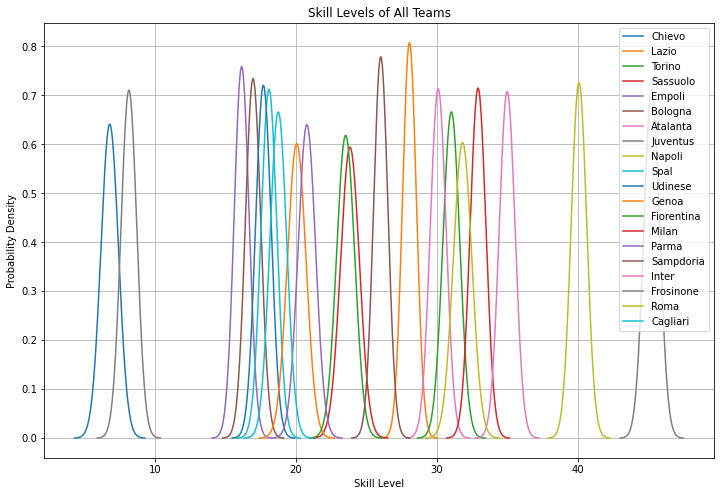

In [23]:
plt.figure(figsize=(12, 8))

for team in team_dicts.keys():
    mean = team_dicts[team]['mean']
    std_dev = np.sqrt(team_dicts[team]['variance'])
    x = np.linspace(mean - 4*std_dev, mean + 4*std_dev, 1000)
    plt.plot(x, norm.pdf(x, mean, std_dev), label=team)

plt.title('Skill Levels of All Teams')
plt.xlabel('Skill Level')
plt.ylabel('Probability Density')
plt.legend()
plt.grid()
plt.show()

# Q6

We want a deterministic way of predicting which team will win each game so no sampling should be used.


The probability of team 1 winning is equal to the probability that the distribution of the outcome is greater than 0: p(y=1) == p(t>0)

In [40]:
def predict_outcome(S1,S2):
    """
    Formula derived in last part of Q3
    """
    ### Calculate mean and variance
    mean_t = S1["mean"]-S2["mean"]
    var_t = S1["variance"]+S2["variance"]  # should actually be: variance of t + variance of S1 + variance(S2)???

    ### Integrate to get probability
    prob_1, _ = integrate.quad(lambda x: norm.pdf(x, mean_t, var_t ** 0.5), 0, float('inf'))
    prob_2 = 1-prob_1

    ### Which is more likely
    if prob_1 > prob_2:
        return 1 # team 1 wins
    else:
        return -1 # team 2 wins
    
### Test
S1 = {"mean": 19, "variance": 0.5}
S2 = {"mean": 20, "variance": 0.5}

print(predict_outcome(S1,S2))


-1


In [46]:
### Initiate all teams equally
team_dicts = initiate_teams(initial_mean, initial_variance)

### Gibbs settings
N = 1000  # Number of samples
B = N//5  # Burn-in index


### Find model performance
correct = 0
random_correct = 0
total_games = len(df)
for index, row in df.iterrows():
    team1 = row['team1']
    team2 = row['team2']
    score1 = row['score1']
    score2 = row['score2']
    
    # Make prediction
    outcome = predict_outcome(team_dicts[team1],team_dicts[team2])
    
    # Determine the outcome 'y'
    if score1 > score2:
        y = 1
    elif score1 < score2:
        y = -1
        
    # Check model prediction against random
    if outcome == y:
        correct+=1
    if np.random.choice([-1,1]) == y:
        random_correct+=1
    
    # Update skill levels using Gibbs sampling
    team_dicts[team1], team_dicts[team2] = gibbs_sampling(team_dicts[team1], team_dicts[team2], y, N, B)
    
print(f"Correctly predicted: {100*np.round((correct/total_games),3)}%")
print(f"Random correct: {100*np.round((random_correct/total_games),3)}%")

Correctly predicted: 65.8%
Random correct: 53.300000000000004%
